# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [1]:
import sys
from pathlib import Path
import warnings
warnings.filterwarnings("ignore", module="IPython")

root_dir = Path().absolute()
# Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
if root_dir.parts[-1:] == ('notebooks',):
    root_dir = Path(*root_dir.parts[:-1])
    sys.path.append(str(root_dir))
if root_dir.parts[-1:] == ('airquality',):
    root_dir = Path(*root_dir.parts[:-1])
    sys.path.append(str(root_dir))
root_dir = str(root_dir) 

print(f"Root dir: {root_dir}")

# Set the environment variables from the file <root_dir>/.env
from mlfs import config
settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Root dir: /home/bruno/Documents/Programming/Cursos/building_ml_systems_with_feature_store/mlfs-book
HopsworksSettings initialized!


In [ ]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from airquality.airquality import util
import os

In [3]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2026, 1, 11, 11, 39, 50, 418721)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [4]:
project = hopsworks.login(api_key_value=os.getenv('HOPSWORKS_API_KEY'))
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

2026-01-11 11:39:50,825 INFO: Initializing external client
2026-01-11 11:39:50,826 INFO: Base URL: https://c.app.hopsworks.ai:443
2026-01-11 11:39:52,491 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1331359


## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [5]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model",
    version=1,
)

fv = retrieved_model.get_feature_view()

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

2026-01-11 11:40:04,601 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/377583 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/118616 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/20490 elapsed<00:00 remaining<?

In [6]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score=[8.994157], booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float'],
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [14]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)
batch_data = weather_fg.filter(weather_fg.date >= today).read()
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.09s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2026-01-14 00:00:00+00:00,22.010500,0.0,13.009903,104.420815,Águas Claras
1,2026-01-17 00:00:00+00:00,24.060501,0.0,6.489992,86.820236,Águas Claras
2,2026-01-16 00:00:00+00:00,22.610500,0.0,11.620809,106.189278,Águas Claras
3,2026-01-13 00:00:00+00:00,23.060501,0.0,7.517021,73.300674,Águas Claras
4,2026-01-12 00:00:00+00:00,23.210501,0.0,8.089993,32.275623,Águas Claras
5,2026-01-15 00:00:00+00:00,22.210501,0.0,16.563911,91.245338,Águas Claras


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [15]:
batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(
    batch_data[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25
0,2026-01-14 00:00:00+00:00,22.010500,0.0,13.009903,104.420815,Águas Claras,8.220616
1,2026-01-17 00:00:00+00:00,24.060501,0.0,6.489992,86.820236,Águas Claras,6.859544
2,2026-01-16 00:00:00+00:00,22.610500,0.0,11.620809,106.189278,Águas Claras,5.847837
3,2026-01-13 00:00:00+00:00,23.060501,0.0,7.517021,73.300674,Águas Claras,8.560662
4,2026-01-12 00:00:00+00:00,23.210501,0.0,8.089993,32.275623,Águas Claras,10.760025
5,2026-01-15 00:00:00+00:00,22.210501,0.0,16.563911,91.245338,Águas Claras,6.797954


In [16]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         6 non-null      datetime64[us, Etc/UTC]
 1   temperature_2m_mean          6 non-null      float32                
 2   precipitation_sum            6 non-null      float32                
 3   wind_speed_10m_max           6 non-null      float32                
 4   wind_direction_10m_dominant  6 non-null      float32                
 5   city                         6 non-null      object                 
 6   predicted_pm25               6 non-null      float32                
dtypes: datetime64[us, Etc/UTC](1), float32(5), object(1)
memory usage: 348.0+ bytes


### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [17]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data = batch_data.sort_values(by=['date'])
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
4,2026-01-12 00:00:00+00:00,23.210501,0.0,8.089993,32.275623,Águas Claras,10.760025,Quadra 206,Brazil,1
3,2026-01-13 00:00:00+00:00,23.060501,0.0,7.517021,73.300674,Águas Claras,8.560662,Quadra 206,Brazil,2
0,2026-01-14 00:00:00+00:00,22.010500,0.0,13.009903,104.420815,Águas Claras,8.220616,Quadra 206,Brazil,3
5,2026-01-15 00:00:00+00:00,22.210501,0.0,16.563911,91.245338,Águas Claras,6.797954,Quadra 206,Brazil,4
2,2026-01-16 00:00:00+00:00,22.610500,0.0,11.620809,106.189278,Águas Claras,5.847837,Quadra 206,Brazil,5
1,2026-01-17 00:00:00+00:00,24.060501,0.0,6.489992,86.820236,Águas Claras,6.859544,Quadra 206,Brazil,6


In [18]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6 entries, 4 to 1
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         6 non-null      datetime64[us, Etc/UTC]
 1   temperature_2m_mean          6 non-null      float32                
 2   precipitation_sum            6 non-null      float32                
 3   wind_speed_10m_max           6 non-null      float32                
 4   wind_direction_10m_dominant  6 non-null      float32                
 5   city                         6 non-null      object                 
 6   predicted_pm25               6 non-null      float32                
 7   street                       6 non-null      object                 
 8   country                      6 non-null      object                 
 9   days_before_forecast_day     6 non-null      int64                  
dtypes: datetime

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

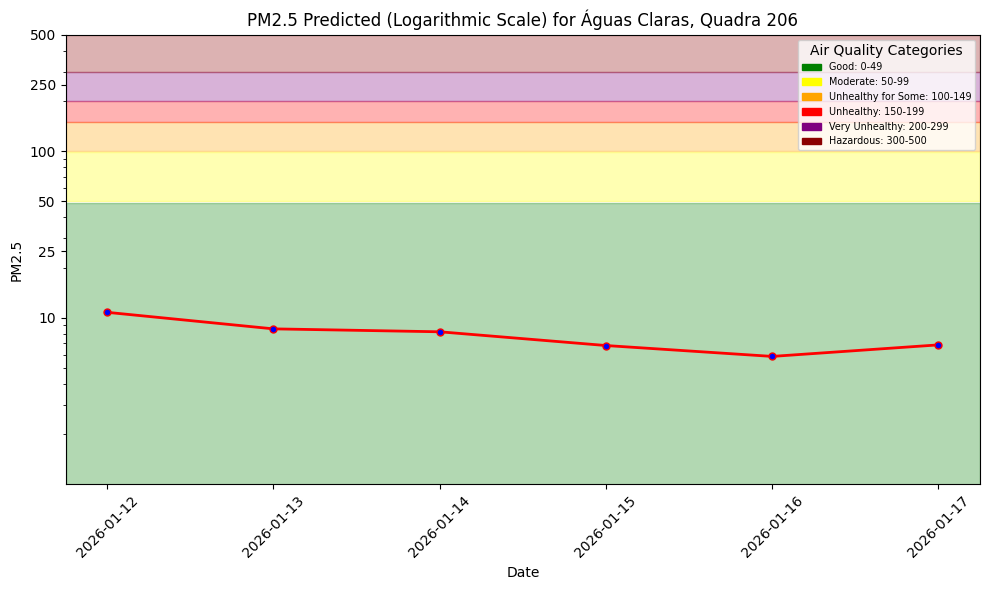

In [19]:

pred_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, pred_file_path)

plt.show()

In [20]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [21]:
monitor_fg.insert(batch_data, wait=True)

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1331359/fs/1320016/fg/1908246


Uploading Dataframe: 100.00% |██████████| Rows 6/6 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1331359/jobs/named/aq_predictions_1_offline_fg_materialization/executions
2026-01-11 11:53:37,424 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2026-01-11 11:53:40,615 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2026-01-11 11:55:35,200 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2026-01-11 11:55:35,394 INFO: Waiting for log aggregation to finish.
2026-01-11 11:55:47,384 INFO: Execution finished successfully.


(Job('aq_predictions_1_offline_fg_materialization', 'SPARK'), None)

In [22]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.27s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
0,2026-01-12 00:00:00+00:00,23.210501,0.0,8.089993,32.275623,Águas Claras,10.760025,Quadra 206,Brazil,1


In [23]:
air_quality_fg = fs.get_feature_group(name='air_quality', version=1)
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.19s) 


,date,pm25,country,city,street,url
0,2024-11-06 00:00:00+00:00,8.0,Brazil,Águas Claras,Quadra 206,https://api.waqi.info/feed/A412909
1,2025-06-19 00:00:00+00:00,2.0,Brazil,Águas Claras,Quadra 206,https://api.waqi.info/feed/A412909
2,2024-04-14 00:00:00+00:00,4.0,Brazil,Águas Claras,Quadra 206,https://api.waqi.info/feed/A412909
3,2024-09-23 00:00:00+00:00,31.0,Brazil,Águas Claras,Quadra 206,https://api.waqi.info/feed/A412909
4,2025-10-01 00:00:00+00:00,29.0,Brazil,Águas Claras,Quadra 206,https://api.waqi.info/feed/A412909
...,...,...,...,...,...,...
719,2024-12-16 00:00:00+00:00,6.0,Brazil,Águas Claras,Quadra 206,https://api.waqi.info/feed/A412909
720,2024-03-26 00:00:00+00:00,11.0,Brazil,Águas Claras,Quadra 206,https://api.waqi.info/feed/A412909
721,2023-10-24 00:00:00+00:00,12.0,Brazil,Águas Claras,Quadra 206,https://api.waqi.info/feed/A412909
722,2025-01-12 00:00:00+00:00,3.0,Brazil,Águas Claras,Quadra 206,https://api.waqi.info/feed/A412909


In [24]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
hindcast_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.92s) 


Uploading Dataframe: 100.00% |██████████| Rows 3/3 | Elapsed Time: 00:02 | Remaining Time: 00:00


Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1331359/jobs/named/aq_predictions_1_offline_fg_materialization/executions
2026-01-11 11:58:16,679 INFO: Waiting for execution to finish. Current state: INITIALIZING. Final status: UNDEFINED
2026-01-11 11:58:19,859 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2026-01-11 11:58:23,047 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2026-01-11 11:59:52,562 INFO: Waiting for execution to finish. Current state: SUCCEEDING. Final status: UNDEFINED
2026-01-11 11:59:55,733 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2026-01-11 11:59:55,899 INFO: Waiting for log aggregation to finish.
2026-01-11 12:00:11,305 INFO: Execution finished successfully.


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,pm25,street,country,days_before_forecast_day
0,2026-01-07 00:00:00+00:00,19.639582,4.4,17.801807,57.250813,Águas Claras,10.896268,2.0,Quadra 206,Brazil,1
1,2026-01-08 00:00:00+00:00,20.685415,1.9,18.556595,79.169212,Águas Claras,4.190896,2.0,Quadra 206,Brazil,1
2,2026-01-11 00:00:00+00:00,22.310501,0.0,15.038350,78.959106,Águas Claras,4.110922,0.0,Quadra 206,Brazil,1


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

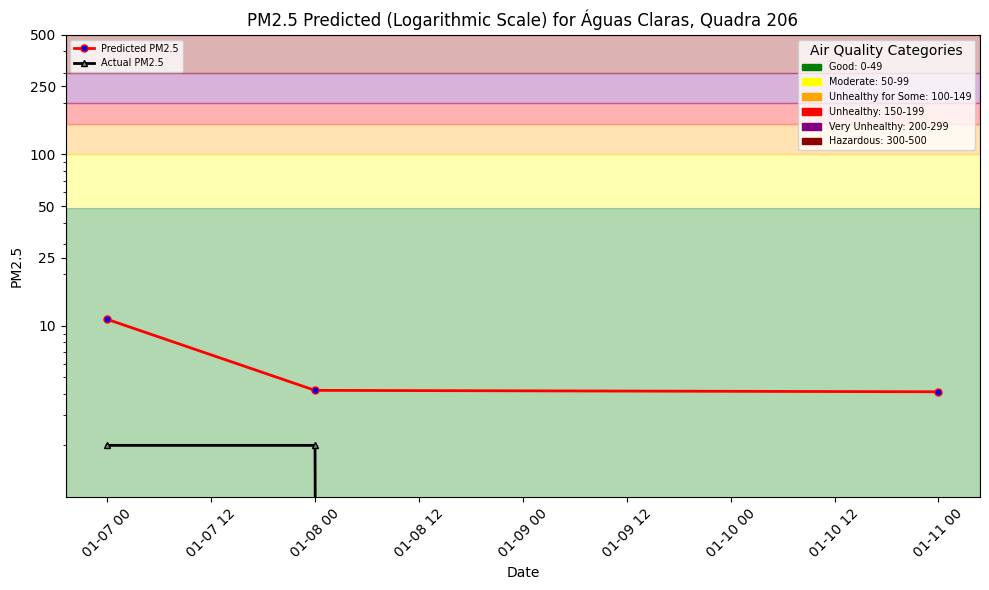

In [28]:
hindcast_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, hindcast_file_path, hindcast=True)
plt.show()

### Upload the prediction and hindcast dashboards (png files) to Hopsworks


In [29]:
dataset_api = project.get_dataset_api()
str_today = today.strftime("%Y-%m-%d")
if dataset_api.exists("Resources/airquality") == False:
    dataset_api.mkdir("Resources/airquality")
dataset_api.upload(pred_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)
dataset_api.upload(hindcast_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)

proj_url = project.get_url()
print(f"See images in Hopsworks here: {proj_url}/settings/fb/path/Resources/airquality")

Uploading /home/bruno/Documents/Programming/Cursos/building_ml_systems_with_feature_store/mlfs-book/docs/air-q…

Uploading /home/bruno/Documents/Programming/Cursos/building_ml_systems_with_feature_store/mlfs-book/docs/air-q…

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1331359/settings/fb/path/Resources/airquality


---